In [1]:
import os
import sys
import imageio
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature
import numpy as np
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from wrf import (to_np, getvar, ALL_TIMES, smooth2d, get_cartopy, 
                 cartopy_xlim, cartopy_ylim, latlon_coords, interplevel,
                geo_bounds, CoordPair, GeoBounds)
%matplotlib inline

# Retrospective Part

## Analysis of the Environment 

In [2]:
def environment_analysis_plotting(variable_name, date, start_hour, 
                                  end_hour, pressure_level=False, 
                                  subset=False, save=False, gif=False):
    """This function plots the chosen variables for the analysis 
    of the environment. Supported variables for plotting procedure 
    are updraft, reflectivity, helicity, pw, cape, cin, ctt, omega, 
    pvo, theta_e, water_vapor, uv_wind"""
    
    ### Preprocessing of data and amalgamation ###
    
    # Get the list of all needed wrf files
    data_directory = "/scratch3/thomasl/work/data/WRF4.0_test51/"

    # Change extent of plot
    variable_subset = GeoBounds(bottom_left=CoordPair(lat=46, lon=5), 
                        top_right=CoordPair(lat=49, lon=9))
    
    # Predefine some variables 
    if variable_name == "updraft":
        variable_name = "W_UP_MAX"
        title_name = "Maximum Z-Wind Updraft"
        colorbar_label = "Max Z-Wind Updraft [$m$ $s^-$$^1$]"
        save_dir = "/scratch3/thomasl/work/retrospective_part"\
                    "/environment_analysis/instability/updraft/"
        save_name = "environment_analysis_updraft_subset"
        variable_min = 0
        variable_max = 35 # original value = 34.5
        levels_step = 0.5
        
    elif variable_name == "reflectivity":
        variable_name = "REFD_MAX"
        title_name = "Maximum Derived Radar Reflectivity"
        colorbar_label = "Maximum Derived Radar Reflectivity [$dBZ$]"
        save_dir = "/scratch3/thomasl/work/retrospective_part"\
                    "/environment_analysis/location/reflectivity/"
        save_name = "environment_analysis_reflectivity_subset"
        variable_min = 0
        variable_max = 58 # original value = 57.6
        levels_step = 1
        
    elif variable_name == "helicity":
        variable_name = "UP_HELI_MAX"
        title_name = "Maximum Updraft Helicity"
        colorbar_label = "Maximum Updraft Helicity [$m^{2}$ $s^{-2}$]"
        save_dir = "/scratch3/thomasl/work/retrospective_part"\
                    "/environment_analysis/instability/helicity/" \
                    "subset/"
        save_name = "environment_analysis_helicity_subset"
        variable_min = 0 
        variable_max = 273 # original value = 272.8
        levels_step = 1
        
    elif variable_name == "pw":
        title_name = "Precipitable Water"
        colorbar_label = "Precipitable Water [$kg$ $m^{-2}$]"
        save_dir = "/scratch3/thomasl/work/retrospective_part"\
                    "/environment_analysis/moisture/" \
                    "precipitable_water/subset/"
        save_name = "environment_analysis_pw_subset"
        variable_min = 2 # original value = 2.8
        variable_max = 47 # original value = 46.4
        levels_step = 1
    
    elif variable_name == "cape":
        variable_name = "cape_2d"
        title_name = "CAPE"
        colorbar_label = "Convective Available Potential Energy" \
                            "[$J$ $kg^{-1}$]"
        save_dir = "/scratch3/thomasl/work/retrospective_part"\
                    "/environment_analysis/instability/cape/"
        save_name = "environment_analysis_cape_subset"
        variable_min = 0 # original value: 0.1
        variable_max = 2700 # original value: 2698.2
        levels_step = 50
        
    elif variable_name == "cin":
        variable_name = "cape_2d"
        title_name = "CIN"
        colorbar_label = "Convective Inhibition [$J$ $kg^{-1}$]"
        save_dir = "/scratch3/thomasl/work/retrospective_part/" \
                "environment_analysis/instability/cin/subset/"
        save_name = "environment_analysis_cin_subset"
        variable_min = 0 # original value = 0.1
        variable_max = 432 # original value = 431.2
        levels_step = 5

    elif variable_name == "ctt":
        title_name = "Cloud Top Temperature"
        colorbar_label = "Cloud Top Temperature [$K$]"
        save_dir = "/scratch3/thomasl/work/retrospective_part"\
                "/environment_analysis/location/cct/"
        save_name = "environment_analysis_cct_subset"
        variable_min = 209 # original value = 209.3
        variable_max = 303 # original value = 302.4
        levels_step = 1
        
    elif variable_name == "omega":
        title_name = "Vertical Motion"
        colorbar_label = "Omega [$Pa$ $s^-$$^1$]"
        save_dir = "/scratch3/thomasl/work/retrospective_part"\
                "/environment_analysis/instability/omega/"
        save_name = "environment_analysis_omega"
        variable_min = -180 # original value = -179.2
        variable_max = 65 # original value = 64.9
        levels_step = 1
        
        # Check if a certain pressure_level was defined.
        if pressure_level == False: 
            sys.exit("The variable "+ variable_name +" is a 3D "\
                     "variable. Definition of a pressure_level for " \
                     "plotting process is required.")
            
    elif variable_name == "pvo":
        title_name = "Potential Vorticity"
        colorbar_label = "Potential Vorticity [$m^2$ $s^{-1}$" \
                            "$K$ $kg^{-1}$]"
        save_dir = "/scratch3/thomasl/work/retrospective_part"\
                "/environment_analysis/instability/pot_vort/"
        save_name = "environment_analysis_pot_vort"
        variable_min = -100 # original value = 1857..8
        variable_max = 100 # original value = 2391.8
        levels_step = 5
        
        # Check if a certain pressure_level was defined.
        if pressure_level == False: 
            sys.exit("The variable "+ variable_name +" is a 3D "\
                     "variable. Definition of a pressure_level for " \
                     "plotting process is required.")
    
    elif variable_name == "theta_e":
        title_name = "Equivalent Potential Temperature"
        colorbar_label = "Theta-E [$K$]"
        save_dir = "/scratch3/thomasl/work/retrospective_part"\
                "/environment_analysis/instability/theta_e/"
        save_name = "environment_analysis_theta_e"
        variable_min = 310 # original value = -14.7
        variable_max = 340 # original value = 553.4
        levels_step = 0.5
        
        # Check if a certain pressure_level was defined.
        if pressure_level == False: 
            sys.exit("The variable "+ variable_name +" is a 3D "\
                     "variable. Definition of a pressure_level for " \
                     "plotting process is required.")
            
    elif variable_name == "water_vapor":
        variable_name = "QVAPOR"
        title_name = "Water Vapor Mixing Ratio"
        colorbar_label = "Water Vapor Mixing Ratio [$kg$ $kg^{-1}$]"
        save_dir = "/scratch3/thomasl/work/retrospective_part"\
                "/environment_analysis/moisture/water_vapor/"
        save_name = "environment_analysis_water_vapor"
        variable_min = -1.7187494e-07
        variable_max = 0.016299415
        levels_step = 0.0001
        
        # Check if a certain pressure_level was defined.
        if pressure_level == False: 
            sys.exit("The variable "+ variable_name +" is a 3D "\
                     "variable. Definition of a pressure_level for " \
                     "plotting process is required.")
    
    elif variable_name == "uv_wind":
        variable_name = "wspd_wdir"
        title_name = "Horizontal Wind Speed and Direction"
        colorbar_label = "Wind Speed [$m$ $s^{-1}$]"
        save_dir = "/scratch3/thomasl/work/retrospective_part"\
                "/environment_analysis/instability/uv_wind/"
        save_name = "environment_analysis_uv_wind"
        variable_min = 0
        variable_max = 30 # original value = 360
        levels_step = 0.5

        # Check if a certain pressure_level was defined.
        if pressure_level == False: 
            sys.exit("The variable "+ variable_name +" is a 3D "\
                     "variable. Definition of a pressure_level for " \
                     "plotting process is required.")

    wrflist = list()
    for (dirpath, dirnames, filenames) in os.walk(data_directory):
        wrflist += [os.path.join(dirpath, file) for file in filenames]
    
    ### Plotting Iteration ###
    
    # Iterate over a list of hourly timesteps
    time = list()
    for i in range(start_hour, end_hour):
        time = str(i).zfill(2)

        # Iterate over all 5 minutes steps of the hours
        for j in range(0, 60, 5):
            minutes = str(j).zfill(2)
                
            # Load the netCDF files out of the wrflist
            ncfile = [Dataset(x) for x in wrflist
                if x.endswith(date + "_" + time +":"+ minutes +":00")]

            # Load Variable
            if title_name == "CAPE":
                variable = getvar(ncfile, variable_name)[0,:]
                
            elif title_name == "CIN":
                variable = getvar(ncfile, variable_name)[1,:]
                
            elif variable_name == "ctt":
                variable = getvar(ncfile, variable_name, units="K")
                    
            else:
                variable = getvar(ncfile, variable_name)

            # Interpolating 3d data to a horizontal pressure level
            if pressure_level != False:
                p = getvar(ncfile, "pressure")
                variable_pressure = interplevel(variable, p, 
                                                pressure_level)
                variable = variable_pressure
                
            if variable_name == "wspd_wdir":
                ua = getvar(ncfile, "ua")
                va = getvar(ncfile, "va")
                u_pressure = interplevel(ua, p, pressure_level)
                v_pressure = interplevel(va, p, pressure_level)
            
            # Define cart projection
            lats, lons = latlon_coords(variable)
            cart_proj = get_cartopy(variable)

            bounds = geo_bounds(wrfin=ncfile)

            # Create figure
            fig = plt.figure(figsize=(15,10))
            ax = plt.axes(projection=cart_proj)

            # Set map bounds
            if subset == True:
                ax.set_xlim(cartopy_xlim(variable, 
                                         geobounds=variable_subset))
                ax.set_ylim(cartopy_ylim(variable, 
                                         geobounds=variable_subset))
            else: 
                ax.set_xlim(cartopy_xlim(variable))
                ax.set_ylim(cartopy_ylim(variable))
                
            # Plot the variable with colorbar
            levels = np.arange(variable_min, variable_max, levels_step)
            
            if title_name == "CIN":
                plt.contourf(to_np(lons), to_np(lats), to_np(variable), 
                             levels=levels, transform=ccrs.PlateCarree(), 
                             cmap=get_cmap("viridis_r"))
            
            elif variable_name == "omega":
                plt.contourf(to_np(lons), to_np(lats), to_np(variable), 
                             levels=levels, transform=ccrs.PlateCarree(), 
                             cmap=get_cmap("viridis_r"))
            
            else:
                plt.contourf(to_np(lons), to_np(lats), to_np(variable), 
                             levels=levels, transform=ccrs.PlateCarree(), 
                             cmap=get_cmap("viridis"))

            cbar = plt.colorbar(ax=ax, orientation="horizontal", 
                                shrink=.45, fraction=0.05, extend="both")
            cbar.set_label(colorbar_label, fontsize=12)
            
            if variable_name == "wspd_wdir":
                # Add the wind barbs of the specific pressure level 
                # plot only every 10th data point
                plt.quiver(to_np(lons[::10,::10]), to_np(lats[::10,::10]),
                            to_np(u_pressure[::10, ::10]), 
                            to_np(v_pressure[::10, ::10]),
                            transform=ccrs.PlateCarree())
            
            # Add borders and coastlines
            ax.add_feature(cfeature.BORDERS.with_scale("10m"), 
                           linewidth=0.8)
            ax.add_feature(cfeature.COASTLINE.with_scale("10m"), 
                           linewidth=0.8)

            # Add gridlines
            gl = ax.gridlines(crs=ccrs.PlateCarree(), color="black", 
                                linestyle="dotted")
            gl.xlabels_top = False
            gl.ylabels_right = False
            gl.xlocator = mticker.FixedLocator(
                [3,4,5,6,7,8,9,10,11,12,13,14])
            gl.ylocator = mticker.FixedLocator([43,44,45,46,47,48,49,50])
            gl.xformatter = LONGITUDE_FORMATTER
            gl.yformatter = LATITUDE_FORMATTER
            gl.xlabel_style = {"size": 15, "color": "gray"}
            gl.ylabel_style = {"size": 15, "color": "gray"}
            
            if pressure_level != False: 
                plt.title(title_name +" @ "+ pressure_level +" hPa (" \
                          + date + " - " + time +":00:00)", fontsize=15)
            else:
                plt.title(title_name +" ("+ date + " - " + time +":" + 
                          minutes+":00)", fontsize=15)
            plt.show()
            
            if save == True:
                # Save the file
                if pressure_level != False: 
                   fig.savefig(save_dir + save_name +"_"+ pressure_level \
                                 +"_"+ date +"_"+ time +":00:00.png")

                else: 
                   fig.savefig(save_dir + save_name +"_"+ date +"_" \
                                 + time +":"+ minutes +":00.png")
        
    if gif == True: 
        ### Make a GIF from the plots ###

        # Predifine some variables
        gif_data_dir = save_dir
        gif_save_dir = "/scratch3/thomasl/work/retrospective_part/"\
                "environment_analysis/gifs/"
        gif_save_name = "environment_analysis_"+ variable_name +".gif"

        # GIF creating procedure
        os.chdir(data_dir)

        image_folder = os.fsencode(data_dir)

        filenames = []

        for file in os.listdir(image_folder):
            filename = os.fsdecode(file)
            if filename.endswith( (".png") ):
                filenames.append(filename)

        filenames.sort() 
        # Iteration technique has no built in order, so sort the frames

        images = list(map(lambda filename: imageio.imread(filename), 
                          filenames))

        imageio.mimsave(os.path.join(save_dir + save_name), 
                        images, duration = 0.50) 


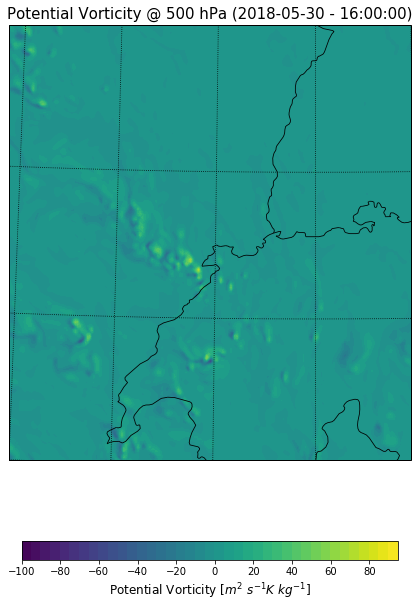

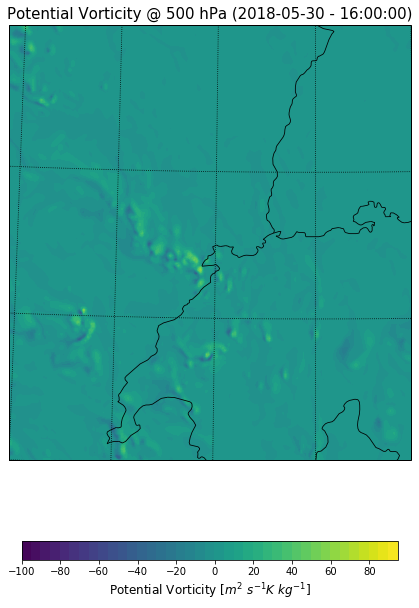

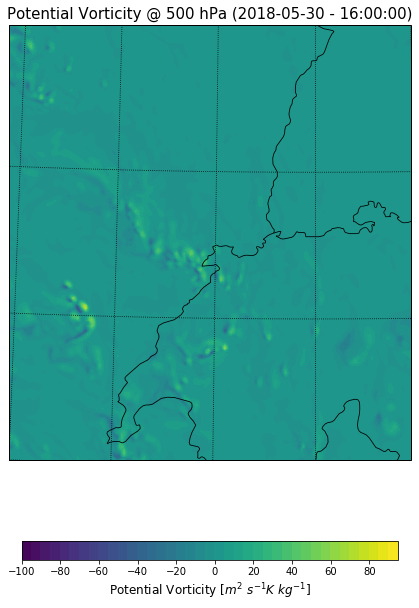

KeyboardInterrupt: 

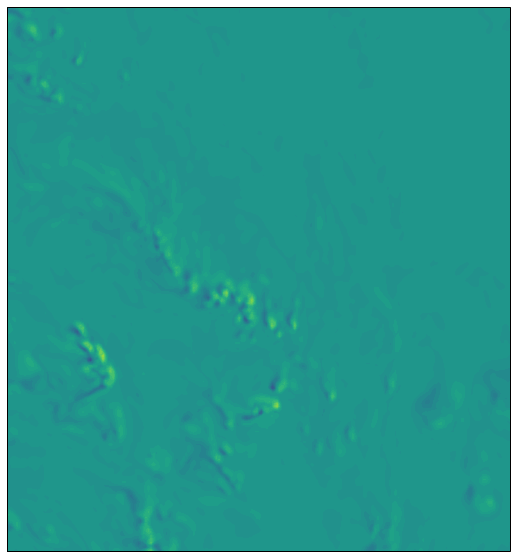

In [4]:
environment_analysis_plotting("pvo", "2018-05-30", 16, 19, 
                               pressure_level="500", subset=True)

In [ ]:
theta_e, water_vapor, uv_wind

In [ ]:
# This was excluded due to performance issues
# Manual set of min and max color bar values

    # Amalgamate all the data files together
    ncfile_alltimes = [Dataset(x) for x in wrflist 
                            if x.endswith("00:00")]
    if variable_name == "cape":
        variable_alltimes = getvar(ncfile_alltimes, variable_name, 
                                    timeidx=ALL_TIMES, method="cat", 
                                    meta=False)[0,:]
            
    elif variable_name == "cin":
        variable_alltimes = getvar(ncfile_alltimes, variable_name, 
                                    timeidx=ALL_TIMES, method="cat", 
                                    meta=False)[1,:]
        
    elif variable_name == "ctt":
         variable_alltimes = getvar(ncfile_alltimes, variable_name, 
                                    timeidx=ALL_TIMES, method="cat", 
                                    meta=False, units="K")
            
    else: 
        variable_alltimes = getvar(ncfile_alltimes, variable_name, 
                                    timeidx=ALL_TIMES, method="cat", 
                                    meta=False)